## Introduction

The data is provided by the medical segmentation decathlon challenge(http://medicaldecathlon.com/) <br />

(Data License: CC-BY-SA 4.0, https://creativecommons.org/licenses/by-sa/4.0/)

In [1]:
!pip install celluloid

In [2]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
import cv2

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
'''
import tarfile
my_tar = tarfile.open('/content/drive/MyDrive/Task06_Lung.tar')
my_tar.extractall('/content/drive/MyDrive/lungData') # specify which folder to extract to
my_tar.close()
'''

KeyboardInterrupt: ignored

In [3]:
# Inspect some sample data
root = Path("D:/projects/CV/msd/Task06_Lung/Task06_Lung/imagesTr/")
label = Path("D:/projects/CV/msd/Task06_Lung/Task06_Lung/labelsTr/")

In [4]:
# Load a sample NIfTI and its corresponding label mask

def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories whithin the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


In [5]:
sample_path = list(root.glob("lung*"))[2] # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [6]:
sample_path, sample_path_label

(WindowsPath('D:/projects/CV/msd/Task06_Lung/Task06_Lung/imagesTr/lung_004.nii.gz'),
 WindowsPath('D:/projects/CV/msd/Task06_Lung/Task06_Lung/labelsTr/lung_004.nii.gz'))

In [7]:
# Load NIfTI and extract image data
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

In [8]:
# Find out the orientation
nib.aff2axcodes(data.affine)

('L', 'A', 'S')

<IPython.core.display.Javascript object>


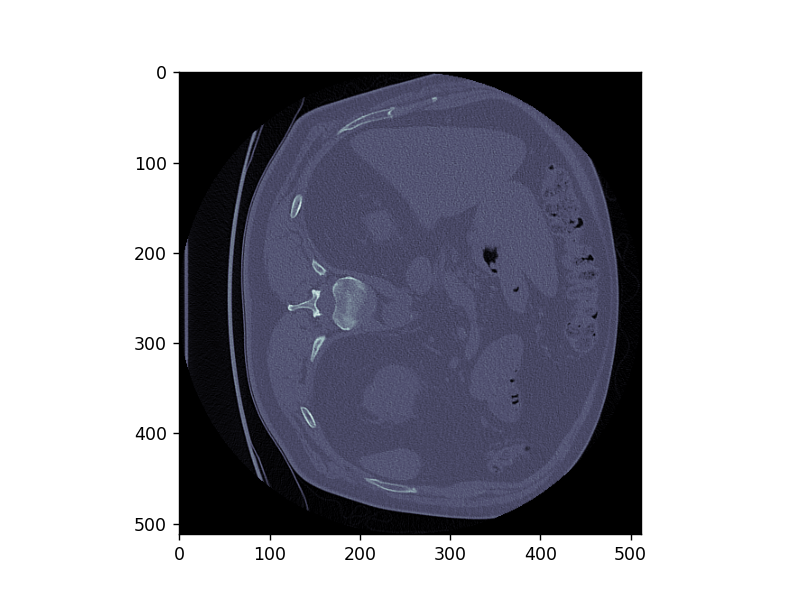

In [9]:
# Inspect the loaded data with overlaid Ground Truth tumor segmentation using axial view
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, ct.shape[2], 2):  # axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    #plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [15]:
#conda install -c conda-forge ffmpeg

^C

Note: you may need to restart the kernel to use updated packages.


In [11]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video


C:\Users\Khushali\anaconda3\envs\tf\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\Khushali\anaconda3\envs\tf\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\Khushali\anaconda3\envs\tf\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


## Preprocessing

1. CT images have a fixed range from -1000 to 3071. **Thus we can normalize by dividing by 3071**
2. As we want to focus on lung tumors, we can crop away parts of the lower abdomen to reduce the complexity and help the network learn. As an example, we might skip the first 30 slices (from lower abdomen to the neck) (last axis)
3. As we want to tackle this task on a slice level (2D) and not on a subject level (3D) to reduce the computational cost we should store the preprocessed data as 2d files, because reading a single slice is much faster than loading the complete NIfTI file.
4. Resize the single slices and masks to (256, 256) (when resizing the mask, pass interpolation=cv2.INTER_NEAREST to the resize function to apply nearest neighbour interpolation)

Loop over all_files and apply the preprocessing steps. <br />

In the preprocessing loop, we need to create a directory for each subject containg the ct and label slices with identical names. <br />
E.g:
* 0/data/0.npy
* 0/masks/0.npy

we will store the last 6 subjects as validation data


In [12]:
all_files = list(root.glob("lung_*"))  # Get all subjects

In [13]:
len(all_files)

63

In [27]:
!pip install ipywidgets widgetsnbextension pandas-profiling

  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=4971a252d132bc694b8b8ba73f66556e679c0d6d38920a4e42baa96f21434a04
  Stored in directory: c:\users\khushali\appdata\local\pip\cache\wheels\1d\05\04\c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9


In [28]:
from tqdm import tqdm
save_root = Path("D:/projects/CV/msd/Task06_Lung/Task06_Lung/Preprocessed-unet")

for counter, path_to_ct_data in enumerate(tqdm(all_files)):
        
    path_to_label = change_img_to_label_path(path_to_ct_data)  # Get path to ground truth
    
    # Load and extract corresponding data
    ct_data = nib.load(path_to_ct_data).get_fdata()
    label_data = nib.load(path_to_label).get_fdata()
    
    # Crop volume and label. Remove the first 30 slices  
    ct_data = ct_data[:,:,30:] / 3071
    label_data = label_data[:,:,30:]
        
    # Check if train or val data and create corresponding path
    if counter < 57:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    # Loop over the slices in the full volume and store the data and labels in the data/masks directory
    for i in range(ct_data.shape[-1]):
        slice = ct_data[:,:,i]
        mask = label_data[:,:,i]
        
        # Resize slice and label to common resolution to reduce training time
        slice = cv2.resize(slice, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)
        
        
    








  0%|                                                                                           | 0/63 [00:00<?, ?it/s]






  2%|█▎                                                                                 | 1/63 [00:29<30:27, 29.48s/it]Exception ignored in: <function tqdm.__del__ at 0x0000025CE06D5E50>
Traceback (most recent call last):
  File "C:\Users\Khushali\anaconda3\envs\tf\lib\site-packages\tqdm\std.py", line 1147, in __del__
    self.close()
  File "C:\Users\Khushali\anaconda3\envs\tf\lib\site-packages\tqdm\notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'







  3%|██▋                                                                                | 2/63 [00:53<26:42, 26.27s/it]






  5%|███▉                                                                               | 3/63 [01:05<19:45, 19.76s/it]






  6%|█████▎                                            

 83%|███████████████████████████████████████████████████████████████████▋              | 52/63 [11:06<02:42, 14.81s/it]






 84%|████████████████████████████████████████████████████████████████████▉             | 53/63 [11:09<01:53, 11.37s/it]






 86%|██████████████████████████████████████████████████████████████████████▎           | 54/63 [11:15<01:28,  9.84s/it]






 87%|███████████████████████████████████████████████████████████████████████▌          | 55/63 [11:32<01:34, 11.80s/it]






 89%|████████████████████████████████████████████████████████████████████████▉         | 56/63 [11:38<01:11, 10.19s/it]






 90%|██████████████████████████████████████████████████████████████████████████▏       | 57/63 [11:45<00:54,  9.15s/it]






 92%|███████████████████████████████████████████████████████████████████████████▍      | 58/63 [11:52<00:42,  8.56s/it]






 94%|████████████████████████████████████████████████████████████████████████████▊     | 59/63 [12:03<00:37,  9.31s/it

## Validate preprocessed data
Take a look at our stored files and inspect if everything worked as expected

In [29]:
path = Path("D:/projects/CV/msd/Task06_Lung/Task06_Lung/Preprocessed-unet/train/2")  # Select a subject. Check the folder if it exists


In [30]:
list(path.glob("*"))

[WindowsPath('D:/projects/CV/msd/Task06_Lung/Task06_Lung/Preprocessed-unet/train/2/data'),
 WindowsPath('D:/projects/CV/msd/Task06_Lung/Task06_Lung/Preprocessed-unet/train/2/masks')]

In [43]:
1# Choose a file and load slice + mask
file = "192.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

<IPython.core.display.Javascript object>


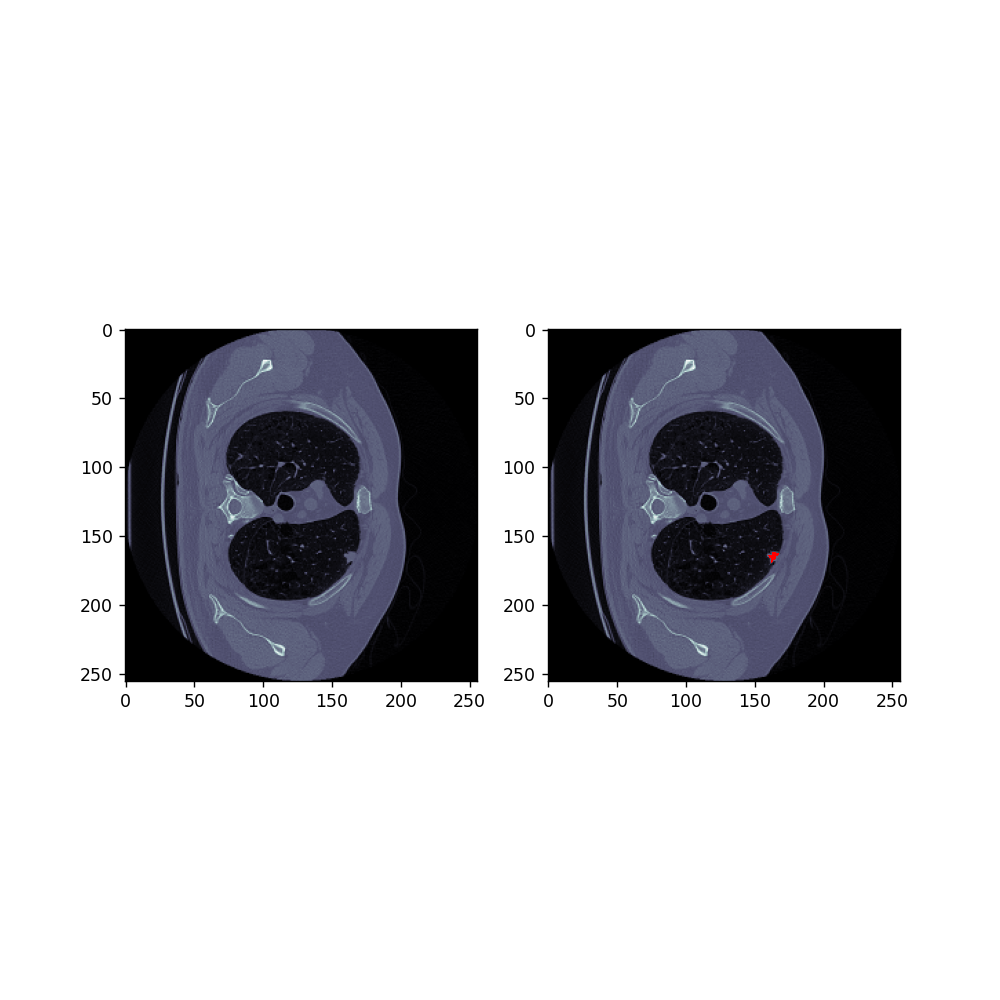

In [44]:
# Plot everything
fig, axis = plt.subplots(1, 2, figsize=(8, 8))
axis[0].imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
axis[1].imshow(slice, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")

In [45]:
print(slice.min(), slice.max())

-0.33344187561055033 0.49967437316834906


## Train

In [46]:
!pip install pytorch_lightning

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0rc0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.4.0 which is incompatible.


  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.21.10
    Uninstalling protobuf-4.21.10:
      Successfully uninstalled protobuf-4.21.10


In [48]:
!pip uninstall imgaug --yes
!pip install imgaug


Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0
  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)


In [51]:
from pathlib import Path

import sys
sys.path.append('C:/Users/Khushali/')

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from dataset import LungDataset
from model import UNet

In [ ]:
 #!cat '/content/drive/MyDrive/model.py'
#!cp "/content/drive/MyDrive/model.py" .

### Dataset Creation

In [52]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15), 
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])


In [53]:
# Create the dataset objects
train_path = Path("D:/projects/CV/msd/Task06_Lung/Task06_Lung/Preprocessed-unet/train/")
val_path = Path("D:/projects/CV/msd/Task06_Lung/Task06_Lung/Preprocessed-unet/val/")

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

Exception ignored in: <function tqdm.__del__ at 0x0000025CE06D5E50>
Traceback (most recent call last):
  File "C:\Users\Khushali\anaconda3\envs\tf\lib\site-packages\tqdm\std.py", line 1147, in __del__
    self.close()
  File "C:\Users\Khushali\anaconda3\envs\tf\lib\site-packages\tqdm\notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


There are 14484 train images and 1283 val images


### Oversampling to tackle strong class imbalance
Lung tumors are often very small, thus we need to make sure that our model does not learn a trivial solution which simply outputs 0 for all voxels.<br />
So, we will use oversampling to sample slices which contain a tumor more often.


In [55]:
# create a list containing only the class labels
from tqdm import tqdm
target_list = []
for _, label in tqdm(train_dataset):
    # Check if mask contains a tumorous pixel:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)


  0%|                                                                                        | 0/14484 [00:00<?, ?it/s]C:\Users\Khushali\anaconda3\envs\tf\lib\site-packages\imgaug\imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)

  2%|█▎                                                                            | 251/14484 [00:09<07:10, 33.03it/s]


  4%|███▎                                                                          | 609/14484 [00:17<05:09, 44.83it/s]


  6%|█████                                                                         | 941/14484 [00:25<08:44, 25.84it/s]


  8%|██████▍                                                                      | 1204/14484 [00:33<05:22, 41.16it/s]


 10%|███████▊                                                                     | 1464/14484 [00:41<07:51, 27.64it/s]


 12%|█████████                                                                    | 1716/14484 [00:50<05:31, 38.56it/s]


 14%|██████████▌                                                                  | 1994/14484 [00:58<07:19, 28.44it/s]


 16%|████████████▏                                                                | 2296/14484 [01:06<04:21, 46.61it/s]


 18%|█████████████▊                                                               | 2589/14484 [01:14<04:22, 45.29it/s]


 21%|███████████████▊                                                             | 2976/14484 [01:22<04:38, 41.37it/s]


 23%|█████████████████▊                                                           | 3360/14484 [01:31<06:25, 28.83it/s]


 25%|███████████████████▎                                                         | 3643/14484 [01:39<03:59, 45.34it/s]


 28%|█████████████████████▎                                                       | 4015/14484 [01:47<04:54, 35.53it/s]


 29%|██████████████████████▋                                                      | 4259/14484 [01:55<07:10, 23.74it/s]


 31%|████████████████████████                                                     | 4521/14484 [02:03<03:36, 46.03it/s]


 34%|██████████████████████████▏                                                  | 4919/14484 [02:11<03:48, 41.91it/s]


 37%|████████████████████████████▎                                                | 5314/14484 [02:19<03:36, 42.27it/s]


 39%|█████████████████████████████▋                                               | 5578/14484 [02:27<05:28, 27.14it/s]


 40%|██████████████████████████████▋                                              | 5778/14484 [02:35<05:18, 27.35it/s]


 42%|████████████████████████████████▍                                            | 6095/14484 [02:43<03:07, 44.66it/s]


 45%|██████████████████████████████████▌                                          | 6508/14484 [02:51<02:47, 47.62it/s]


 48%|████████████████████████████████████▊                                        | 6918/14484 [02:59<02:22, 53.09it/s]


 50%|██████████████████████████████████████▎                                      | 7195/14484 [03:08<04:38, 26.19it/s]


 52%|███████████████████████████████████████▉                                     | 7503/14484 [03:15<02:26, 47.80it/s]


 54%|█████████████████████████████████████████▎                                   | 7780/14484 [03:24<04:08, 26.93it/s]


 56%|██████████████████████████████████████████▉                                  | 8087/14484 [03:32<02:19, 45.92it/s]


 59%|█████████████████████████████████████████████                                | 8484/14484 [03:40<02:01, 49.24it/s]


 61%|███████████████████████████████████████████████▏                             | 8876/14484 [03:48<01:54, 49.17it/s]


 64%|█████████████████████████████████████████████████▎                           | 9273/14484 [03:56<01:47, 48.29it/s]


 67%|███████████████████████████████████████████████████▍                         | 9665/14484 [04:05<02:56, 27.27it/s]


 68%|████████████████████████████████████████████████████▍                        | 9870/14484 [04:13<03:19, 23.13it/s]


 70%|█████████████████████████████████████████████████████▍                      | 10189/14484 [04:21<01:35, 45.00it/s]


 73%|███████████████████████████████████████████████████████▎                    | 10534/14484 [04:29<02:22, 27.74it/s]


 74%|████████████████████████████████████████████████████████▍                   | 10759/14484 [04:37<02:42, 22.97it/s]


 77%|██████████████████████████████████████████████████████████▎                 | 11108/14484 [04:45<01:39, 33.96it/s]


 79%|███████████████████████████████████████████████████████████▊                | 11395/14484 [04:53<01:27, 35.12it/s]


 81%|█████████████████████████████████████████████████████████████▎              | 11676/14484 [05:01<01:22, 34.24it/s]


 83%|██████████████████████████████████████████████████████████████▊             | 11965/14484 [05:09<01:04, 38.84it/s]


 85%|████████████████████████████████████████████████████████████████▋           | 12325/14484 [05:17<00:42, 50.21it/s]


 88%|██████████████████████████████████████████████████████████████████▊         | 12730/14484 [05:25<00:31, 55.28it/s]


 91%|████████████████████████████████████████████████████████████████████▉       | 13132/14484 [05:33<00:27, 49.42it/s]


 93%|██████████████████████████████████████████████████████████████████████▉     | 13524/14484 [05:41<00:19, 49.84it/s]


 96%|█████████████████████████████████████████████████████████████████████████   | 13913/14484 [05:50<00:10, 53.26it/s]


 99%|███████████████████████████████████████████████████████████████████████████ | 14303/14484 [05:58<00:03, 46.55it/s]


100%|████████████████████████████████████████████████████████████████████████████| 14484/14484 [06:02<00:00, 39.99it/s]


In [56]:
# calculate the weight for each class
uniques = np.unique(target_list, return_counts=True)
uniques

(array([0, 1]), array([12969,  1515], dtype=int64))

In [57]:
fraction = uniques[1][0] / uniques[1][1]
fraction = float(format(fraction, '.2f'))

In [58]:
weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)

In [59]:
weight_list[:50]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [60]:
# Finally we create the sampler which we can pass to the DataLoader.
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))                     


In [61]:
batch_size = 8#TODO
num_workers = 2# TODO


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [62]:
# We can verify that our sampler works by taking a batch from the train loader and count how many labels are larger than zero
verify_sampler = next(iter(train_loader))  # Take one batch

In [63]:
(verify_sampler[1][:,0]).sum([1, 2]) > 0  # ~ half the batch size 

tensor([ True, False,  True,  True, False, False,  True,  True])

### Loss

As this is a harder task to train we might try different loss functions:
We achieved best results by using the Binary Cross Entropy instead of the Dice Loss

In [64]:
# Full Segmentation Model
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        
        pred = self(ct)
        loss = self.loss_fn(pred, mask)
        self.logger.experiment.add_scalar("Loss/Train", loss, self.current_epoch) #added by KA
        # Logs
        self.log("Train Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss
    
        
    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()

        pred = self(ct)
        loss = self.loss_fn(pred, mask)
        self.logger.experiment.add_scalar("Loss/Val", loss, self.current_epoch) #added by KA
        
        # Logs
        self.log("Val Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss

    
    def log_images(self, ct, pred, mask, name):
        
        results = []
        
        pred = pred > 0.5 # As we use the sigomid activation function, we threshold at 0.5
        
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0]==0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")
        
        axis[1].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0]==0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)

            
    
    def configure_optimizers(self):
        #We always need to return a list here (just pack our optimizer into one :))
        return [self.optimizer]



In [65]:
# Instanciate the model

model = TumorSegmentation()


In [66]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=30,
    mode='min')

In [69]:
# Create the trainer
gpus = 1 if torch.cuda.is_available() else 0
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="D:/projects/CV/msd/Task06_Lung/Task06_Lung/logs-unet"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=1)


C:\Users\Khushali\anaconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [70]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [75]:
from tqdm import tqdm
trainer.fit(model, train_loader, val_loader)


  | Name    | Type              | Params
----------------------------------------------
0 | model   | UNet              | 7.8 M 
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs/

### Evaluation:
Let's evaluate the results

In [ ]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()  # Counter       
        denum = pred.sum() + mask.sum()  # denominator
        dice = (2*counter)/denum
        
        return dice


In [ ]:
model = TumorSegmentation.load_from_checkpoint("/content/epoch=29-step=53759.ckpt")
model.eval();
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [ ]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).float().to(device).unsqueeze(0)
    with torch.no_grad():
        pred = torch.sigmoid(model(slice))
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

In [ ]:
dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

### Visualization


In [ ]:
THRESHOLD = 0.5

In [ ]:
import nibabel as nib
import cv2

In [ ]:
subject = Path("/content/lungData/Task06_Lung/imagesTs/lung_013.nii.gz")
ct = nib.load(subject).get_fdata() / 3071  # standardize
ct = ct[:,:,30:]  # crop

In [ ]:
segmentation = []
label = []
scan = []

for i in range(ct.shape[-1]):
    slice = ct[:,:,i]
    slice = cv2.resize(slice, (256, 256))
    slice = torch.tensor(slice)
    scan.append(slice)
    slice = slice.unsqueeze(0).unsqueeze(0).float().to(device)
    
    with torch.no_grad():
        pred = model(slice)[0][0].cpu()
    pred = pred > THRESHOLD
    segmentation.append(pred)
    label.append(segmentation)
    

In [ ]:
# Plotting the predicted segmentation (red)
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, len(scan), 2):  # Sagital view. Skip every second slice to reduce the video length
    plt.imshow(scan[i], cmap="bone")
    mask = np.ma.masked_where(segmentation[i]==0, segmentation[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")  # Use autumn colormap to get red segmentation 
    
    plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video
